In [1]:
import os
import glob
import importlib

import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl

import analyze2p.plotting as pplot
import analyze2p.gratings.utils as gutils 
import analyze2p.utils as hutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.extraction.traces as traceutils
import analyze2p.gratings.bootstrap_osi as osi

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
#importlib.reload(traceutils)

In [3]:
%matplotlib notebook

# Select dataset

In [4]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(lw_axes=0.25)
# src dirs
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'

In [5]:
responsive_test='ROC'
# -----------------------------
response_type='dff'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
print(responsive_test, responsive_thr)
n_bootstrap_iters=500
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, responsive_test=responsive_test, 
                            responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters)
data_id = '|'.join([traceid, ori_fit_desc])
print(data_id)

ROC 0.05
traces001|fit-dff_responsive-ROC-thr0.05_boot-500


In [6]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
metad = sdata[sdata.experiment.isin(['gratings'])].copy()
dkeys = [(va, dk) for (va, dk), g in metad.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
            if (va, dk) in dkeys])
CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates().groupby(['visual_area']).count()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


,animalid,session,fovnum
visual_area,,,
Li,15,15,15
Lm,9,9,9
V1,9,9,9


# Output dir

In [7]:
base_dir = os.path.join(aggregate_dir, 'FIGURES', '2p_traces')
figid = '%s-%s' % (traceid, ori_fit_desc)
print(figid)
dst_dir = os.path.join(base_dir, 'examples')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

FIGDIR = dst_dir
print(FIGDIR)

traces001-fit-dff_responsive-ROC-thr0.05_boot-500
/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/2p_traces/examples
/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/2p_traces/examples


# Load gratings data

In [8]:
gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, create_new=False,
                            fit_desc=ori_fit_desc, return_missing=True) 
gdata = hutils.split_datakey(gdata)

In [9]:
gdata.head()
print(ori_fit_desc)

fit-dff_responsive-ROC-thr0.05_boot-500


In [10]:
df_thr=0.35
best_ = gdata.groupby(['cell'])['response_pref']\
                    .transform(max) == gdata['response_pref']
bestg_ = gdata.loc[best_].copy()

bestg_[bestg_['response_pref']>=df_thr].groupby(['visual_area', 'datakey']).count()

response_pref  response_null  theta_pref  \
visual_area datakey                                                         
Li          20190602_JC091_fov1              1              1           1   
            20190607_JC091_fov1              1              1           1   
            20190609_JC099_fov1              1              1           1   
            20190614_JC091_fov1              3              3           3   
            20191111_JC120_fov1              1              1           1   
Lm          20190512_JC083_fov1              2              2           2   
            20190513_JC078_fov1              7              7           7   
            20190517_JC083_fov1              2              2           2   
            20190525_JC084_fov1              3              3           3   
            20190603_JC080_fov1              3              3           3   
            20190618_JC097_fov1              2              2           2   
            20190627_JC091_fov1              3              3           3   
V1          20190511_JC083_fov1              7              7           7   
            20190512_JC083_fov1              1              1           1   
            20190522_JC084_fov1              6              6           6   
            20190613_JC097_fov1              1              1           1   
            20190616_JC097_fov1              3              3           3   
            20190617_JC097_fov1              3              3           3   
            20190622_JC085_fov1             15             15          15   
            20191006_JC110_fov1              1              1           1   

                                 sigma  response_offset  asi  dsi  \
visual_area datakey                                                 
Li          20190602_JC091_fov1      1                1    1    1   
            20190607_JC091_fov1      1                1    1    1   
            20190609_JC099_fov1      1                1    1    1   
            20190614_JC091_fov1      3                3    3    3   
            20191111_JC120_fov1      1                1    1    1   
Lm          20190512_JC083_fov1      2                2    2    2   
            20190513_JC078_fov1      7                7    7    7   
            20190517_JC083_fov1      2                2    2    2   
            20190525_JC084_fov1      3                3    3    3   
            20190603_JC080_fov1      3                3    3    3   
            20190618_JC097_fov1      2                2    2    2   
            20190627_JC091_fov1      3                3    3    3   
V1          20190511_JC083_fov1      7                7    7    7   
            20190512_JC083_fov1      1                1    1    1   
            20190522_JC084_fov1      6                6    6    6   
            20190613_JC097_fov1      1                1    1    1   
            20190616_JC097_fov1      3                3    3    3   
            20190617_JC097_fov1      3                3    3    3   
            20190622_JC085_fov1     15               15   15   15   
            20191006_JC110_fov1      1                1    1    1   

                                 circvar_asi  circvar_dsi  r2  cell  r2comb  \
visual_area datakey                                                           
Li          20190602_JC091_fov1            1            1   1     1       1   
            20190607_JC091_fov1            1            1   1     1       1   
            20190609_JC099_fov1            1            1   1     1       1   
            20190614_JC091_fov1            3            3   3     3       3   
            20191111_JC120_fov1            1            1   1     1       1   
Lm          20190512_JC083_fov1            2            2   2     2       2   
            20190513_JC078_fov1            7            7   7     7       7   
            20190517_JC083_fov1            2            2   2     2       2   
            20190525_JC084_fo

In [12]:
va='V1'
dk = '20190511_JC083_fov1'
df_thr=0.3
# va='V1'
# dk = '20190511_JC083_fov1'

ncells_pass = len(gdata[(gdata['response_pref']>=df_thr) 
      & (gdata['visual_area']==va) & (gdata['datakey']==dk)]['cell'].unique())
print("{}: {}, n={} cells".format(va, dk, ncells_pass))
df = gdata[(gdata['response_pref']>=df_thr) 
      & (gdata['visual_area']==va) & (gdata['datakey']==dk)].copy()

V1: 20190511_JC083_fov1, n=12 cells


## Load traces

In [13]:
### Load traces
data_fpath = traceutils.get_data_fpath(dk, experiment_name='gratings')
print(data_fpath)
raw_traces, labels, sdf, run_info = traceutils.load_dataset(data_fpath, 
                                                    trace_type='corrected')
dff_traces, trialmetrics = aggr.process_traces(raw_traces, labels, 
                        trace_type='dff', 
                        response_type='dff', trial_epoch='stimulus')

/n/coxfs01/2p-data/JC083/20190511/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_1d60f5_traces001_36512c_traces001_d39be1_traces001_7f9d03_traces001_1bfee5/data_arrays/corrected.npz
--- processed traces: dff


In [14]:
ori_values = sorted(sdf['ori'].unique())

In [15]:
# Fit params
fitresults, fitparams = gutils.load_tuning_results(dk, 
                                fit_desc=ori_fit_desc, traceid=traceid)
all_cfg_vals = sorted([tuple(c) for c in fitparams['nonori_configs']])
all_cfg_vals

[(0.1, 20.0, 20),
 (0.1, 40.0, 20),
 (0.1, 200.0, 20),
 (0.5, 20.0, 20),
 (0.5, 40.0, 20),
 (0.5, 200.0, 20)]

In [16]:
best_of = df.groupby(['cell'])['gof']\
                    .transform(max) == df['gof']
bestg = df.loc[best_of].copy()
bestg.shape

(12, 21)

In [239]:
rois0 = bestg.sort_values(by='gof', ascending=False)['cell'].values[0:15]
len(rois0)

12

In [240]:
excl= [107, 143]
rois = [r for r in rois0 if r not in excl]
len(rois)

10

In [241]:
nr = len(rois)
nc = len(ori_values)
fontsize=6

smooth_traces=True
windowsz = 9
smooth_traces = True
col='k'
ri=0

In [242]:
plotg = bestg[bestg['cell'].isin(rois)]
plotg.shape

(10, 21)

<IPython.core.display.Javascript object>


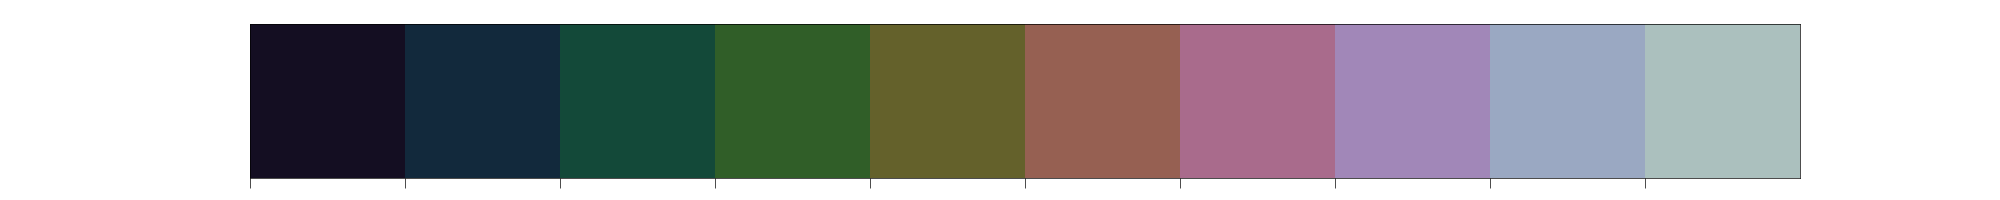

In [243]:
# colors
tested_thetas = sorted(sdf['ori'].unique())
cmap='cubehelix'
cmap_d = pplot.darken_cmap(colormap=cmap, alpha=0.8)
sns.palplot(sns.color_palette(cmap_d, n_colors=len(rois)))
roi_colors = sns.color_palette(palette=cmap_d, n_colors=len(rois))
roi_cdict = dict((k, v) for k, v in zip(rois, roi_colors))

In [244]:
sorted(rois)


[26, 27, 32, 105, 117, 119, 128, 156, 164, 166]

In [245]:
%matplotlib notebook

In [254]:
figid = '%s\n%s|%s' % (data_id, va, dk)
figid

'traces001|fit-dff_responsive-ROC-thr0.05_boot-500\nV1|20190511_JC083_fov1'

<IPython.core.display.Javascript object>


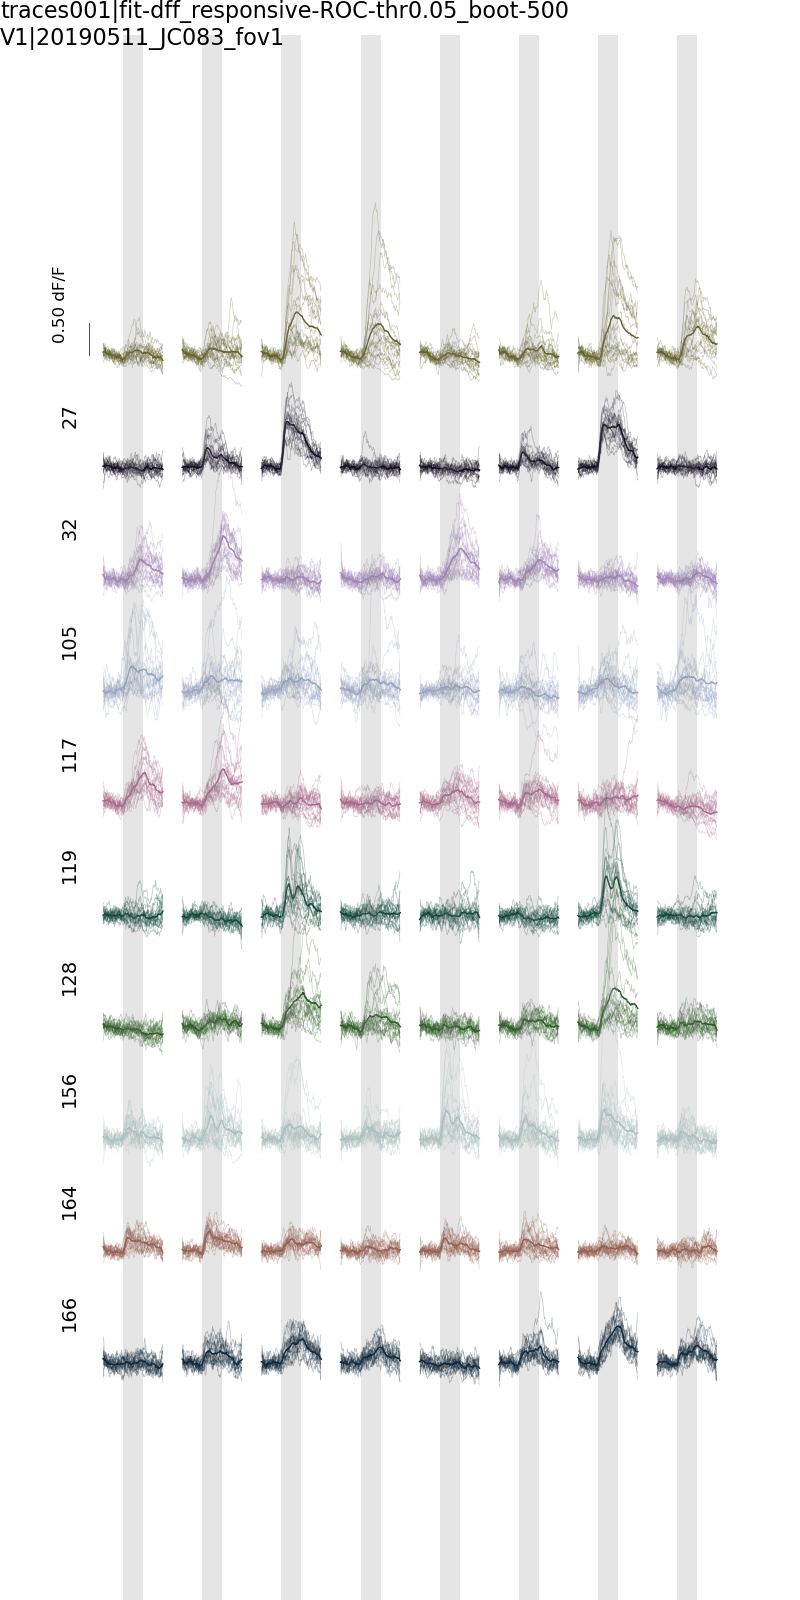

In [263]:

fig, axes = pl.subplots(nr, nc, 
                    figsize=(4,8), sharex=True, sharey=True)

for ri, (rid, val_df) in enumerate(plotg.groupby(['cell'])):
    cfg_vals = val_df[['sf', 'size', 'speed']].iloc[0]
    currconfigs = fitresults[rid][tuple(cfg_vals)]['stimulus_configs']
    currlabels = labels[labels['config'].isin(currconfigs)]
    col = roi_cdict[rid]
    for cf, (cfg, g) in enumerate(currlabels.groupby(['config'])):
        curr_ori = sdf['ori'][cfg] #.copy()
        plot_ix = ori_values.index(curr_ori)
        ax = axes[ri, plot_ix] #axes[ci, plot_ix]
        if plot_ix==0:
            ax.set_ylabel(rid)
        ax.patch.set(alpha=0)
        for trial, tdf in g.groupby(['trial']):
            tsec = tdf['tsec'].values
            tvals = dff_traces[rid][tdf.index].values
            st = traceutils.temporal_downsample(tsec, windowsz) if smooth_traces else tsec
            sm = traceutils.temporal_downsample(tvals, windowsz) if smooth_traces else tvals
            ax.plot(st, sm, color=col, alpha=0.3, lw=0.25)
        meantrace = np.nanmean(np.array([dff_traces[rid][gg.index] \
                        for trial, gg in g.groupby(['trial'])]), axis=0)
        sm = traceutils.temporal_downsample(meantrace, windowsz) if smooth_traces else meantrace
        ax.plot(tsec, sm, color=col, alpha=1, lw=0.5)
        # ax.tick_params(which='both', axis='both', size=0)

pl.subplots_adjust(hspace=-0.5) #, bottom=0, top=1)
pplot.clean_axes(axes, ymax=0.5)
pplot.add_stimulus_patch(fig, axes, ori_values, stim_dur=1, x=0, y=-3)

pplot.label_figure(fig, figid)
pl.savefig(os.path.join(dst_dir, 'traces_%s.svg' % dk))

In [39]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

In [85]:
import tifffile as tf
import analyze2p.retinotopy.utils as retutils

In [83]:
session, animalid, fovnum = hutils.split_datakey_str(dk)
tfs = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_*' % fovnum,
                      'gratings_run1', 'processed/processed*', 
                       'mcorrected*_deinterleaved', 'Channel01', 'File*', '*.tif'))
i_=[]
for t in tfs:
    im = tf.imread(t)
    i_.append(im)
imstack = np.dstack(i_)

In [110]:
df['experiment'] = 'gratings'
gdata['experiment'] = 'gratings'

In [112]:
celldf = gdata[['visual_area', 'datakey', 'cell', 'experiment']].drop_duplicates()
roipos = aggr.add_roi_positions(celldf)
roipos.head()

,visual_area,datakey,cell,experiment,animalid,fov,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
0,Li,20190314_JC070_fov1,230,gratings,JC070,FOV1_zoom2p0x,20190314,576.125245,250.0,550.174560,289.0,422.625440,601.474755
1,Li,20190314_JC070_fov1,232,gratings,JC070,FOV1_zoom2p0x,20190314,562.298239,244.0,527.329941,277.0,445.470059,615.301761
2,Li,20190314_JC070_fov1,233,gratings,JC070,FOV1_zoom2p0x,20190314,495.467710,215.0,519.715068,273.0,453.084932,682.132290
3,Li,20190314_JC070_fov1,245,gratings,JC070,FOV1_zoom2p0x,20190314,960.976908,417.0,569.211742,299.0,403.588258,216.623092
4,Li,20190314_JC070_fov1,246,gratings,JC070,FOV1_zoom2p0x,20190314,972.499413,422.0,584.441487,307.0,388.358513,205.100587


In [116]:
pos = roipos[(roipos['visual_area']==va) & (roipos['datakey']==dk)]
pos.head()

,visual_area,datakey,cell,experiment,animalid,fov,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
2350,V1,20190511_JC083_fov1,1,gratings,JC083,FOV1_zoom2p0x,20190511,161.315068,70.0,243.675930,128.0,729.124070,1016.284932
2354,V1,20190511_JC083_fov1,2,gratings,JC083,FOV1_zoom2p0x,20190511,186.664579,81.0,264.616830,139.0,708.183170,990.935421
2355,V1,20190511_JC083_fov1,4,gratings,JC083,FOV1_zoom2p0x,20190511,129.052055,56.0,411.203131,216.0,561.596869,1048.547945
2359,V1,20190511_JC083_fov1,7,gratings,JC083,FOV1_zoom2p0x,20190511,96.789041,42.0,485.448141,255.0,487.351859,1080.810959
2361,V1,20190511_JC083_fov1,8,gratings,JC083,FOV1_zoom2p0x,20190511,41.481018,18.0,502.581605,264.0,470.218395,1136.118982


In [120]:
pos.index = pos['cell']

<IPython.core.display.Javascript object>


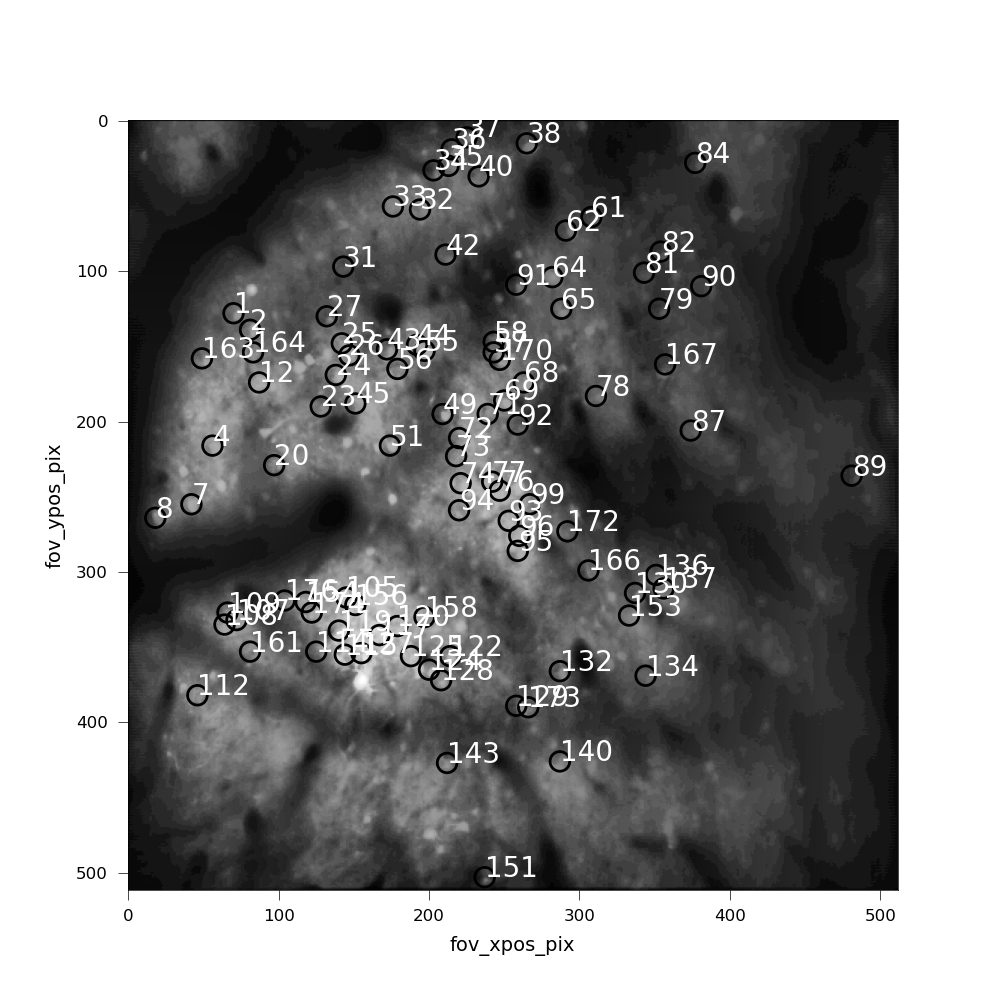

In [127]:
meanr = imstack.mean(axis=-1)
# pixel_size = hutils.get_pixel_size()  
#fov_transformed = retutils.transform_2p_fov(meanr, pixel_size, normalize=True)
#zimg_r = pplot.adjust_image_contrast(fov_transformed, clip_limit=10.0, tile_size=5)
zimg = pplot.adjust_image_contrast(meanr, clip_limit=10.0, tile_size=5)
fig, ax = pl.subplots(figsize=(5,5))
ax.imshow(zimg, cmap='gray')
sns.scatterplot(x='fov_xpos_pix', y='fov_ypos_pix', 
                data=pos, ax=ax, #hue='none', 
                s=50,linewidth=1, edgecolor='k', facecolor='none')
for rid in pos['cell'].unique():
    ax.text(pos.loc[rid]['fov_xpos_pix'], pos.loc[rid]['fov_ypos_pix'], int(rid), 
                        fontsize=10, color='w')


In [133]:
pos['cell']

cell
1        1
2        2
4        4
7        7
8        8
      ... 
170    170
172    172
173    173
174    174
176    176
Name: cell, Length: 96, dtype: int64

In [137]:
pos['color'] = [roi_cdict[roi] if roi in rois else 'k' for roi in pos['cell'].values]

In [135]:
rois

array([ 27, 166, 119, 128,  26, 164, 117,  32, 107, 105, 143, 156])

In [136]:
roi_colors

[(0.07237896895991251, 0.04356572888185908, 0.11082198804864572),
 (0.07975776666148326, 0.12641243800469382, 0.21674806878470754),
 (0.06573888568266854, 0.23470628675295552, 0.24454159120996818),
 (0.10188449677285816, 0.3255048603269846, 0.20084077761057695),
 (0.22873028524190442, 0.3768499728504699, 0.1499111496225202),
 (0.41518234058216213, 0.38335823838932015, 0.17690854789682076),
 (0.5753237154016525, 0.3792661409032059, 0.30399871511666465),
 (0.6605191179941439, 0.4056400754238887, 0.5005983987173852),
 (0.6537865952218205, 0.48319208341806974, 0.6734090015368284),
 (0.6152930298802872, 0.5886342101002862, 0.7547268860099083),
 (0.615403816544135, 0.6941559417323356, 0.7588535790657657),
 (0.6912717555064203, 0.7635656808170181, 0.7500621122368607)]

<IPython.core.display.Javascript object>


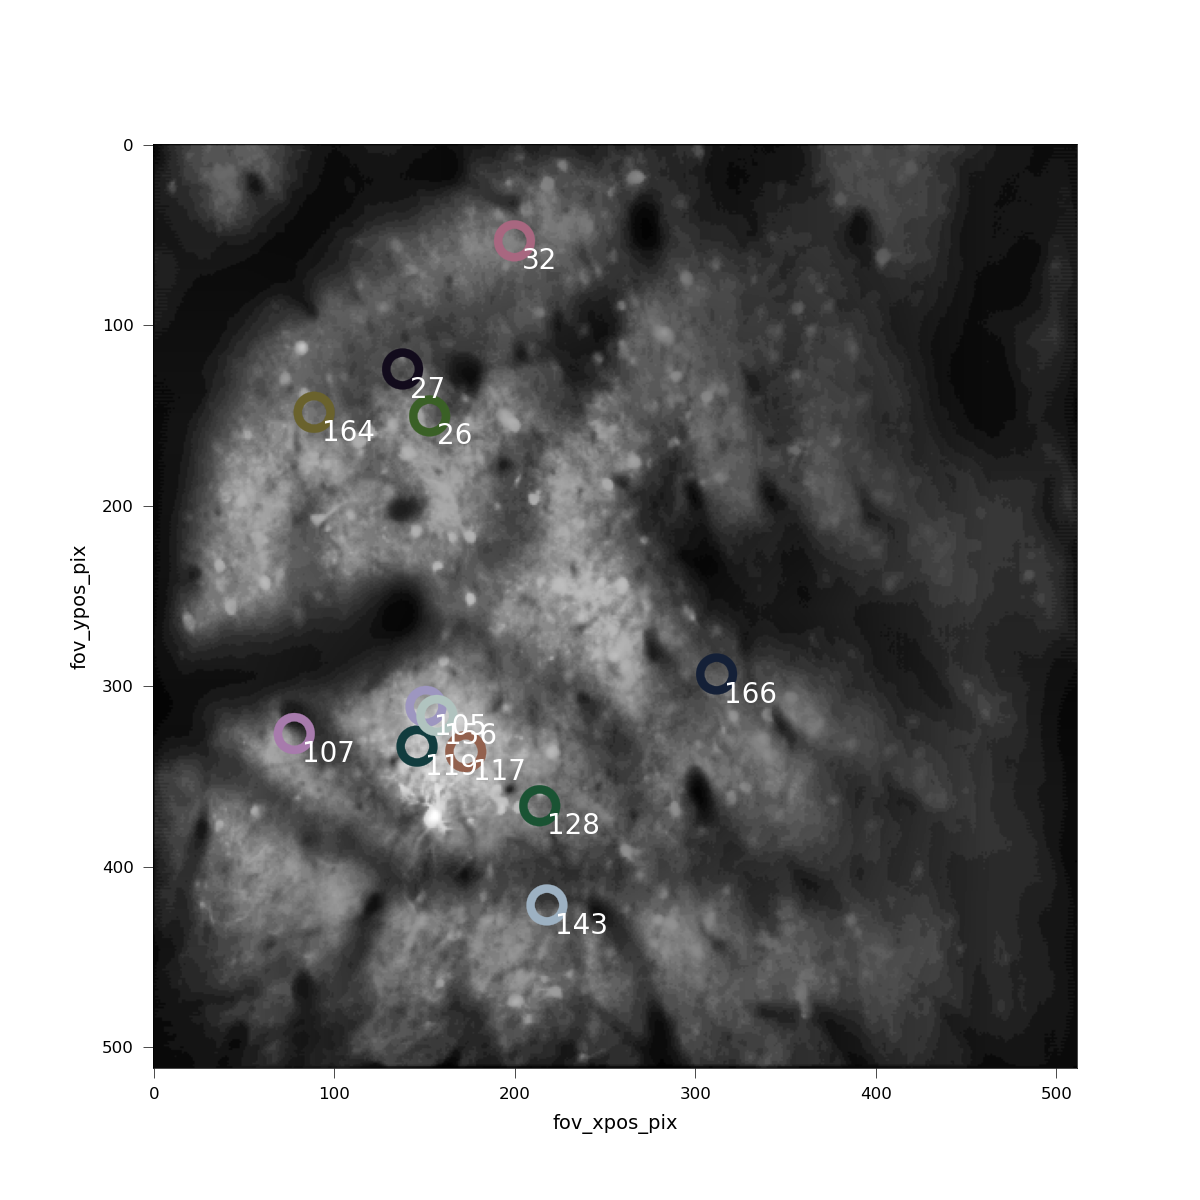

In [218]:

zimg = pplot.adjust_image_contrast(meanr, clip_limit=10.0, tile_size=5)
fig, ax = pl.subplots(figsize=(6,6))
ax.imshow(zimg, cmap='gray')
sns.scatterplot(x='fov_xpos_pix', y='fov_ypos_pix', 
                data=pos.loc[rois], ax=ax, legend=False,
                marker="$\circ$", ec="face", hue='color', palette=cmap_d,
                s=500, linewidth=0.1) #, #edgecolor='k', facecolor='none')
for rid in rois: #pos['cell'].unique():
    ax.text(pos.loc[rid]['fov_xpos_pix']+10, pos.loc[rid]['fov_ypos_pix']+10, int(rid), 
                        fontsize=10, color='w')


In [156]:
dk

'20190511_JC083_fov1'

In [153]:
import analyze2p.extraction.rois as roiutils

In [160]:
session, animalid, fovnum = hutils.split_datakey_str(dk)
fov='FOV%i_zoom2p0x'
roiid = 'rois001'
masks, zimg = roiutils.load_roi_masks(animalid, session, fov, rois=roiid)

<IPython.core.display.Javascript object>


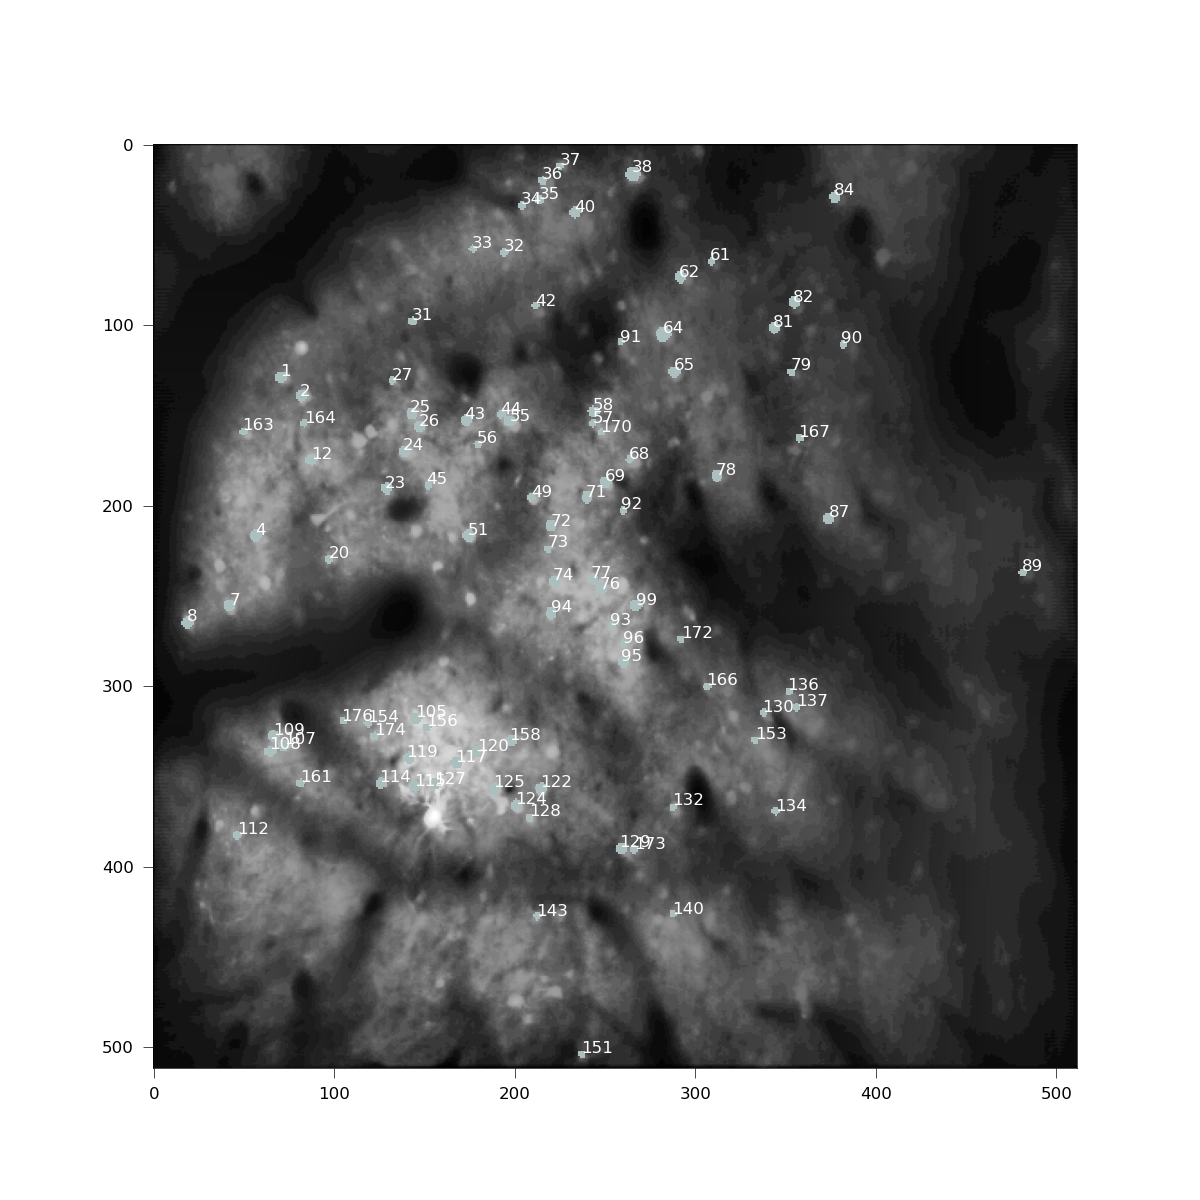

In [261]:
fig, ax = pl.subplots(figsize=(6,6))#pl.imshow(zimg, cmap='gray')
ax.imshow(zimg, cmap='gray')
for rid in pos['cell'].unique():
    #roi = rid+1
    msk = masks[rid,:,:].copy() 
    msk[msk==0] = np.nan
    #customcm = mpl.colors.ListedColormap( [roi_cdict[rid] ] )
    ax.imshow(msk, alpha=1, cmap=customcm ) # cmap='Reds')
for rid in pos['cell'].unique():
    ax.text(pos.loc[rid]['fov_xpos_pix'], pos.loc[rid]['fov_ypos_pix'], int(rid), 
                        fontsize=6, color='w')

    

In [215]:
import matplotlib as mpl
import cv2

<IPython.core.display.Javascript object>


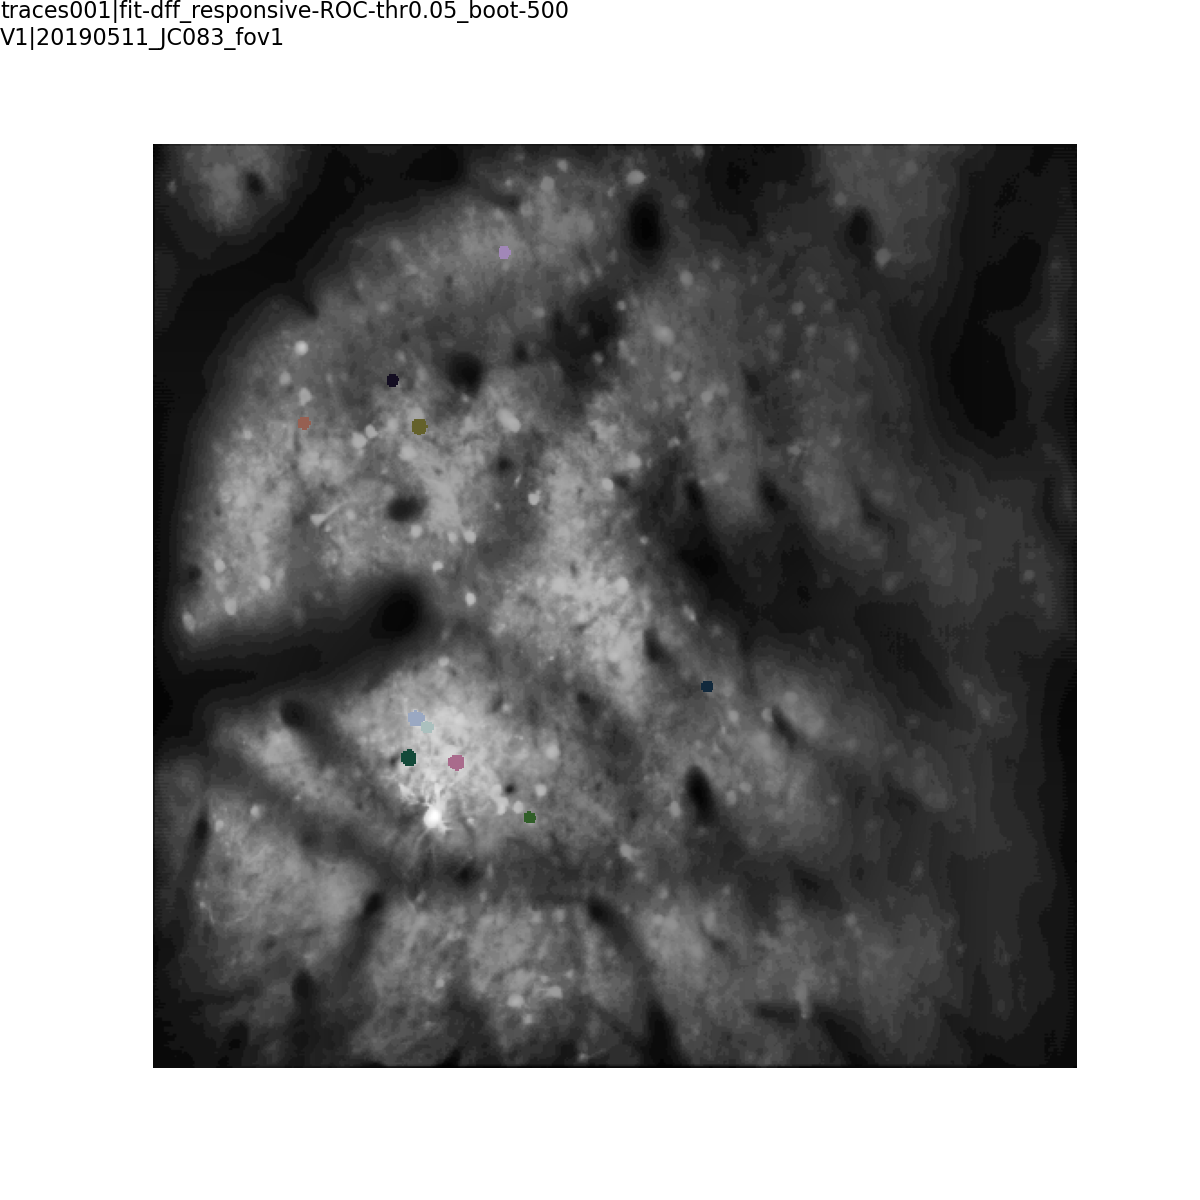

In [262]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

fig, ax = pl.subplots(figsize=(6,6))#pl.imshow(zimg, cmap='gray')
ax.imshow(zimg, cmap='gray')
for rid in rois:
    #roi = rid+1
    msk = masks[rid,:,:].copy() 
    msk2 = cv2.dilate(msk, kernel, iterations=1)
    msk2[msk2==0] = np.nan
    customcm = mpl.colors.ListedColormap( [roi_cdict[rid] ] )
    ax.imshow(msk2, alpha=1, cmap=customcm ) # cmap='Reds')
ax.axis('off')
# for rid in rois: #pos['cell'].unique():
#     ax.text(pos.loc[rid]['fov_xpos_pix'], pos.loc[rid]['fov_ypos_pix'], int(rid), 
#                         fontsize=6, color='w')


pplot.label_figure(fig, figid)
pl.savefig(os.path.join(dst_dir, 'fov_%s.svg' % dk))